In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd
!ls
%cd /content/drive/MyDrive/depression


/content
drive  sample_data
/content/drive/MyDrive/depression


In [ ]:
import pandas as pd
#pandas
import numpy as np
#numpy
import matplotlib.pyplot as plt
#matplotlib
import seaborn as sns
#seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
#sklearn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
#from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
#keras
import tensorflow as tf
#tensorflow
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#nltk
import os
import nltk # For NLP
import re # For Regex 
import string # For punctuation
#other useful stuff
from wordcloud import WordCloud, STOPWORDS
#wordclouds and cloud stopwords
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin', header=None)

In [ ]:
data.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [ ]:
data = data.rename(columns={0: 'target', 1: 'id', 2: 'date', 3: 'query', 4: 'username', 5: 'content'})

In [ ]:
data.head(10)

,target,id,date,query,username,content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [ ]:
missing_data = data.isna().sum().sort_values(ascending=False)
percentage_missing = round((data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info.style.background_gradient()

,Missing values,Percentage
content,0,0.000000
username,0,0.000000
query,0,0.000000
date,0,0.000000
id,0,0.000000
target,0,0.000000


In [ ]:
pd.set_option('display.max_colwidth', -1)
data[data['target']==0]['content'].head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
1    is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    
2    @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          
3    my whole body feels itchy and like its on fire                                                                     
4    @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     
Name: content, dtype: object

In [ ]:
data[data['target']==4]['content'].head

<bound method NDFrame.head of 800000     I LOVE @Health4UandPets u guys r the best!!                                                                                              
800001     im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!                                                                 
800002     @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. 
800003     Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup                                 
800004     @LovesBrooklyn2 he has that effect on everyone                                                                                           
                                ...                                                                                                                 
1599995    Just woke up. Having no school is the best feeling ever          

In [ ]:
data[data['target']==2]['content'].head

<bound method NDFrame.head of Series([], Name: content, dtype: object)>

In [ ]:
data['target'] = data['target'].replace([0, 4],['Negative','Positive'])

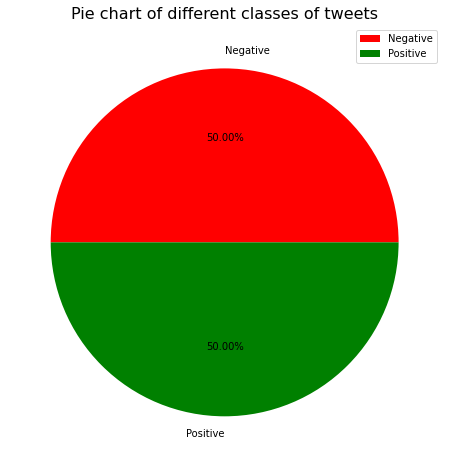

In [ ]:
fig = plt.figure(figsize=(8,8))
targets = data.groupby('target').size()
targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['red','green'])
plt.title("Pie chart of different classes of tweets",fontsize=16)
plt.ylabel("")
plt.legend()
plt.show()

In [ ]:
data['target'].value_counts()

Negative    800000
Positive    800000
Name: target, dtype: int64

In [ ]:
data['length'] = data.content.str.split().apply(len)

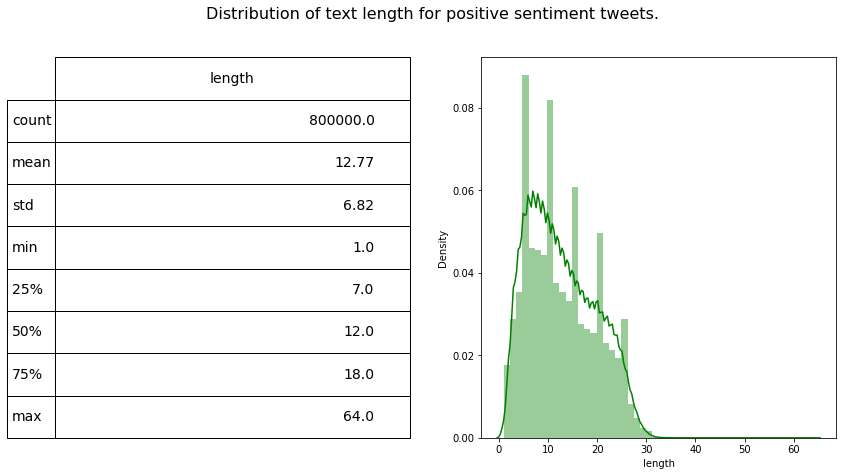

In [ ]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='Positive']['length'], ax=ax1,color='green')
describe = data.length[data.target=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

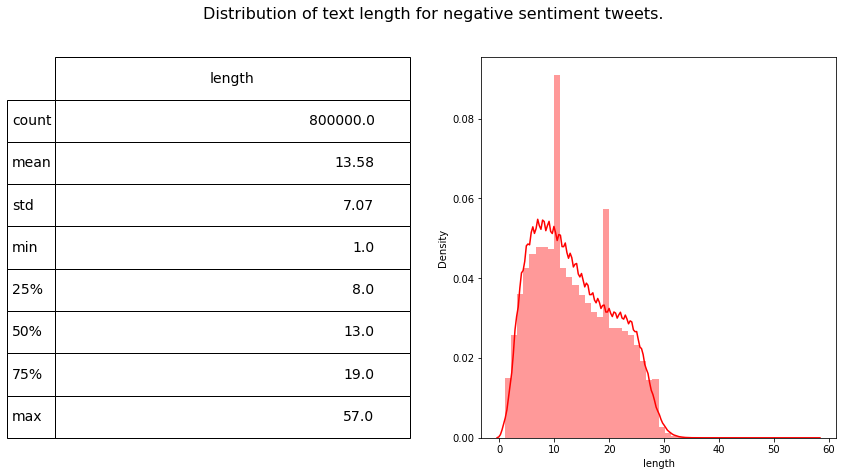

In [ ]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='Negative']['length'], ax=ax1,color='red')
describe = data.length[data.target=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

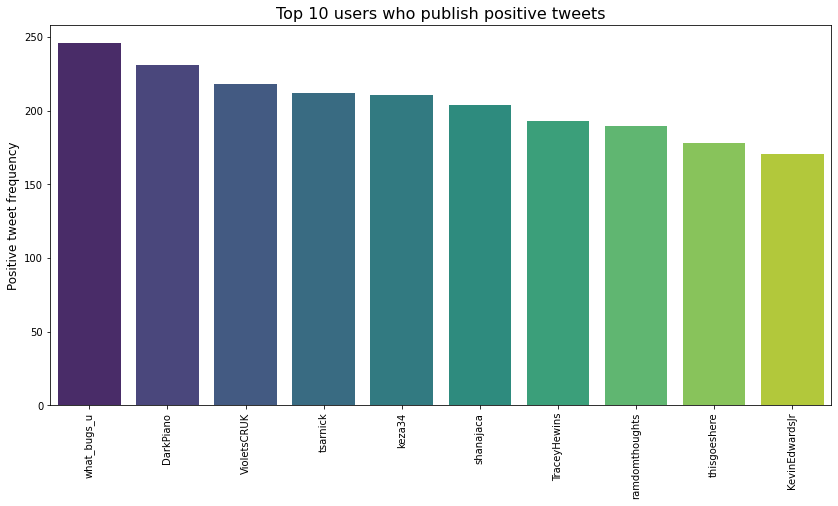

In [ ]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='Positive']['username'].value_counts()[:10].index, \
                           y=data[data['target']=='Positive']['username'].value_counts()[:10],palette='viridis')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Positive tweet frequency',fontsize=12)
plt.title('Top 10 users who publish positive tweets',fontsize=16)
plt.show()

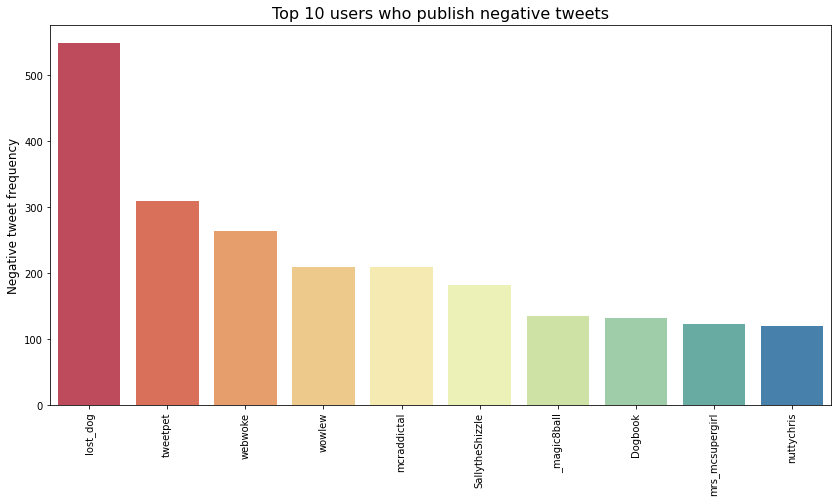

In [ ]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='Negative']['username'].value_counts()[:10].index, \
                           y=data[data['target']=='Negative']['username'].value_counts()[:10],palette='Spectral')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Negative tweet frequency',fontsize=12)
plt.title('Top 10 users who publish negative tweets',fontsize=16)
plt.show()

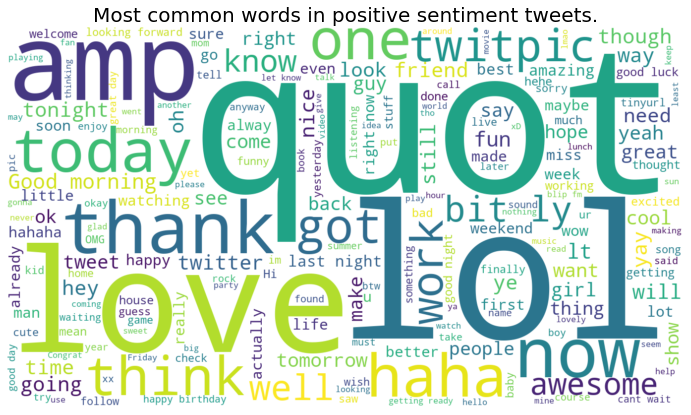

In [ ]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Positive'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in positive sentiment tweets.',fontsize=20)
plt.show()

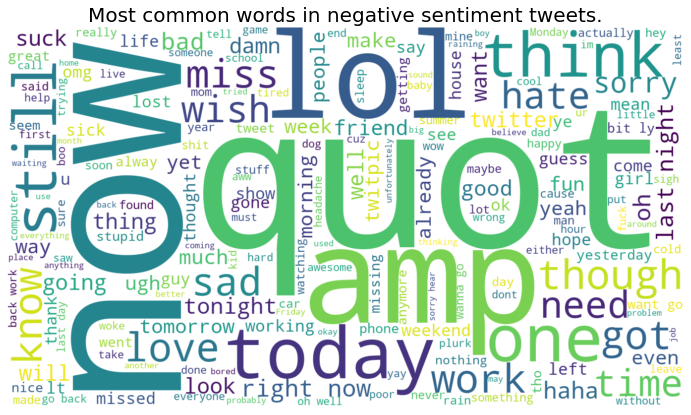

In [ ]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='Negative'].content))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in negative sentiment tweets.',fontsize=20)
plt.show()

In [ ]:
data.drop(['id','date','query','username','length'], axis=1, inplace=True)

In [ ]:
data.target = data.target.replace({'Positive': 1, 'Negative': 0})

In [ ]:
from string import punctuation
print("DATA CLEANING -- \n")
# emojis defined
emoji_pattern = re.compile("["
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

def replace_emojis(t):
  '''
  This function replaces happy unicode emojis with "happy" and sad unicode emojis with "sad.
  '''
  emoji_happy = ["\U0001F600", "\U0001F601", "\U0001F602","\U0001F603","\U0001F604","\U0001F605", "\U0001F606", "\U0001F607", "\U0001F609", 
                "\U0001F60A", "\U0001F642","\U0001F643","\U0001F923",r"\U0001F970","\U0001F60D", r"\U0001F929","\U0001F618","\U0001F617",
                r"\U000263A", "\U0001F61A", "\U0001F619", r"\U0001F972", "\U0001F60B", "\U0001F61B", "\U0001F61C", r"\U0001F92A",
                "\U0001F61D", "\U0001F911", "\U0001F917", r"\U0001F92D", r"\U0001F92B","\U0001F914","\U0001F910", r"\U0001F928", "\U0001F610", "\U0001F611",
                "\U0001F636", "\U0001F60F","\U0001F612", "\U0001F644","\U0001F62C","\U0001F925","\U0001F60C","\U0001F614","\U0001F62A",
                "\U0001F924","\U0001F634", "\U0001F920", r"\U0001F973", r"\U0001F978","\U0001F60E","\U0001F913", r"\U0001F9D0"]

  emoji_sad = ["\U0001F637","\U0001F912","\U0001F915","\U0001F922", r"\U0001F92E","\U0001F927", r"\U0001F975", r"\U0001F976", r"\U0001F974",
                       "\U0001F635", r"\U0001F92F", "\U0001F615","\U0001F61F","\U0001F641", r"\U0002639","\U0001F62E","\U0001F62F","\U0001F632",
                       "\U0001F633", r"\U0001F97A","\U0001F626","\U0001F627","\U0001F628","\U0001F630","\U0001F625","\U0001F622","\U0001F62D",
                       "\U0001F631","\U0001F616","\U0001F623"	,"\U0001F61E","\U0001F613","\U0001F629","\U0001F62B", r"\U0001F971",
                       "\U0001F624","\U0001F621","\U0001F620", r"\U0001F92C","\U0001F608","\U0001F47F","\U0001F480", r"\U0002620"]

  words = t.split()
  reformed = []
  for w in words:
    if w in emoji_happy:
      reformed.append("happy")
    elif w in emoji_sad:
      reformed.append("sad") 
    else:
      reformed.append(w)
  t = " ".join(reformed)
  return t


def replace_smileys(t):
  '''
  This function replaces happy smileys with "happy" and sad smileys with "sad.
  '''
  emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}', ':D',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3'])

  emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('])  

  words = t.split()
  reformed = []
  for w in words:
    if w in emoticons_happy:
      reformed.append("happy")
    elif w in emoticons_sad:
      reformed.append("sad") 
    else:
      reformed.append(w)
  t = " ".join(reformed)
  return t

def replace_contractions(t):
  '''
  This function replaces english lanuage contractions like "shouldn't" with "should not"
  '''
  cont = {"aren't" : 'are not', "can't" : 'cannot', "couln't": 'could not', "didn't": 'did not', "doesn't" : 'does not',
  "hadn't": 'had not', "haven't": 'have not', "he's" : 'he is', "she's" : 'she is', "he'll" : "he will", 
  "she'll" : 'she will',"he'd": "he would", "she'd":"she would", "here's" : "here is", 
   "i'm" : 'i am', "i've"	: "i have", "i'll" : "i will", "i'd" : "i would", "isn't": "is not", 
   "it's" : "it is", "it'll": "it will", "mustn't" : "must not", "shouldn't" : "should not", "that's" : "that is", 
   "there's" : "there is", "they're" : "they are", "they've" : "they have", "they'll" : "they will",
   "they'd" : "they would", "wasn't" : "was not", "we're": "we are", "we've":"we have", "we'll": "we will", 
   "we'd" : "we would", "weren't" : "were not", "what's" : "what is", "where's" : "where is", "who's": "who is",
   "who'll" :"who will", "won't":"will not", "wouldn't" : "would not", "you're": "you are", "you've":"you have",
   "you'll" : "you will", "you'd" : "you would", "mayn't" : "may not"}
  words = t.split()
  reformed = []
  for w in words:
    if w in cont:
      reformed.append(cont[w])
    else:
      reformed.append(w)
  t = " ".join(reformed)
  return t  

def remove_single_letter_words(t):
  '''
  This function removes words that are single characters
  '''
  words = t.split()
  reformed = []
  for w in words:
    if len(w) > 1:
      reformed.append(w)
  t = " ".join(reformed)
  return t  

print("Cleaning the tweets from the data.\n")
print("Replacing handwritten emojis with their feeling associated.")
print("Convert to lowercase.")
print("Replace contractions.")
print("Replace unicode emojis with their feeling associated.")
print("Remove all other unicoded emojis.")
print("Remove NON- ASCII characters.")
print("Remove numbers.")
print("Remove \"#\". ")
print("Remove \"@\". ")
print("Remove usernames.")
print("Remove \'RT\'. ")
print("Replace all URLs and Links with word \'URL\'.")
print("Remove all punctuations.")
print("Removes single letter words.\n")

def dataclean(t):
  '''
  This function cleans the tweets.
  '''
  t = replace_smileys(t) # replace handwritten emojis with their feeling associated
  t = t.lower() # convert to lowercase
  t = replace_contractions(t) # replace short forms used in english  with their actual words
  t = replace_emojis(t) # replace unicode emojis with their feeling associated
  t = emoji_pattern.sub(r'', t) # remove emojis other than smiley emojis
  t = re.sub('\\\\u[0-9A-Fa-f]{4}','', t) # remove NON- ASCII characters
  t = re.sub("[0-9]", "", t) # remove numbers # re.sub("\d+", "", t)
  t = re.sub('#', '', t) # remove '#'
  t = re.sub('@[A-Za-z0–9]+', '', t) # remove '@'
  t = re.sub('@[^\s]+', '', t) # remove usernames
  t = re.sub('RT[\s]+', '', t) # remove retweet 'RT'
  t = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', t) # remove links (URLs/ links)
  t = re.sub('[!"$%&\'()*+,-./:@;<=>?[\\]^_`{|}~]', '', t) # remove punctuations
  t = t.replace('\\\\', '')
  t = t.replace('\\', '')
  t = remove_single_letter_words(t) # removes single letter words
  
  return t

data['content'] = data['content'].apply(dataclean)
print("Tweets have been cleaned.")

DATA CLEANING -- 

Cleaning the tweets from the data.

Replacing handwritten emojis with their feeling associated.
Convert to lowercase.
Replace contractions.
Replace unicode emojis with their feeling associated.
Remove all other unicoded emojis.
Remove NON- ASCII characters.
Remove numbers.
Remove "#". 
Remove "@". 
Remove usernames.
Remove 'RT'. 
Replace all URLs and Links with word 'URL'.
Remove all punctuations.
Removes single letter words.

Tweets have been cleaned.


In [ ]:
data.head()

,target,content
0,0,awww that is bummer you shoulda got david carr of third day to do it
1,0,is upset that he cannot update his facebook by texting it and might cry as result school today also blah
2,0,dived many times for the ball managed to save the rest go out of bounds
3,0,my whole body feels itchy and like its on fire
4,0,no it is not behaving at all am mad why am here because cannot see you all over there


In [ ]:
english_stopwords = stopwords.words('english')
#base of english stopwords
stemmer = SnowballStemmer('english')
#stemming algorithm
regex = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
#regex for mentions and links in tweets

In [ ]:
def preprocess(content, stem=False):
  content = re.sub(regex, ' ', str(content).lower()).strip()
  tokens = []
  for token in content.split():
    if token not in english_stopwords:
      tokens.append(stemmer.stem(token))
  return " ".join(tokens)

In [ ]:
data.content = data.content.apply(lambda x: preprocess(x))

In [ ]:
data.head()

,target,content
0,0,awww bummer shoulda got david carr third day
1,0,upset cannot updat facebook text might cri result school today also blah
2,0,dive mani time ball manag save rest go bound
3,0,whole bodi feel itchi like fire
4,0,behav mad cannot see


In [ ]:
train, test = train_test_split(data, test_size=0.1, random_state=44)

In [ ]:
print('Train dataset shape: {}'.format(train.shape))
print('Test dataset shape: {}'.format(test.shape))

Train dataset shape: (1440000, 2)
Test dataset shape: (160000, 2)


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.content)  
vocab_size = len(tokenizer.word_index) + 1 
max_length = 50

In [ ]:
sequences_train = tokenizer.texts_to_sequences(train.content) 
sequences_test = tokenizer.texts_to_sequences(test.content) 

X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

y_train = train.target.values
y_test = test.target.values

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('glove.6B.100d.txt')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embeddings_matrix[index] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False)

In [ ]:
num_epochs = 70
batch_size = 1000

In [ ]:
model = Sequential([
        embedding_layer,
        tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
        tf.keras.layers.Dropout(0.4),
       # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Bidirectional(LSTM(128)),
        tf.keras.layers.Dropout(0.4),
       # tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           34169400  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 256)           234496    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

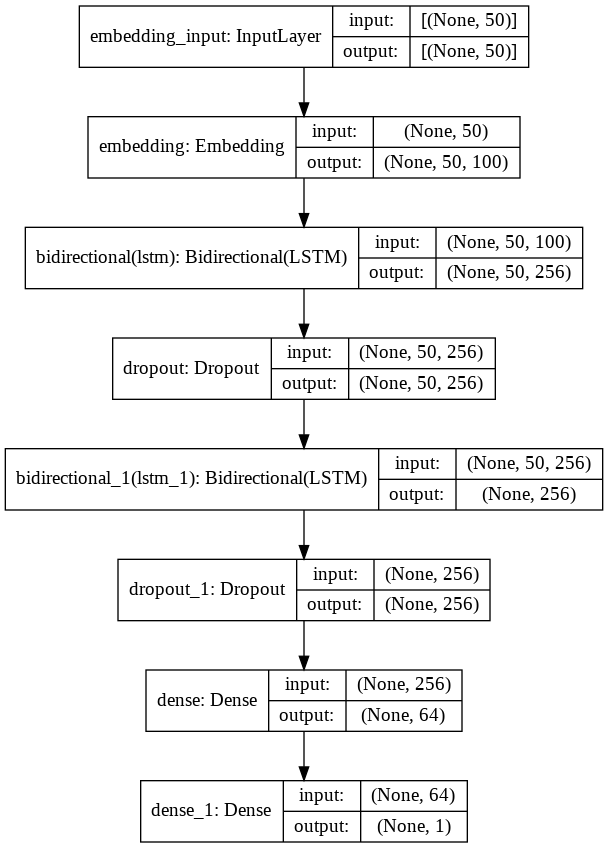

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, batch_size = batch_size, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)# , callbacks=[es])

Epoch 1/70
1440/1440 [==============================] - 170s 94ms/step - loss: 0.5556 - accuracy: 0.7110 - val_loss: 0.5048 - val_accuracy: 0.7506
Epoch 2/70
1440/1440 [==============================] - 136s 95ms/step - loss: 0.5014 - accuracy: 0.7520 - val_loss: 0.4941 - val_accuracy: 0.7566
Epoch 3/70
1440/1440 [==============================] - 136s 95ms/step - loss: 0.4895 - accuracy: 0.7605 - val_loss: 0.4867 - val_accuracy: 0.7614
Epoch 4/70
1440/1440 [==============================] - 136s 95ms/step - loss: 0.4808 - accuracy: 0.7661 - val_loss: 0.4825 - val_accuracy: 0.7645
Epoch 5/70
1440/1440 [==============================] - 137s 95ms/step - loss: 0.4745 - accuracy: 0.7698 - val_loss: 0.4827 - val_accuracy: 0.7659
Epoch 6/70
1440/1440 [==============================] - 136s 95ms/step - loss: 0.4677 - accuracy: 0.7743 - val_loss: 0.4793 - val_accuracy: 0.7668
Epoch 7/70
1440/1440 [==============================] - 136s 95ms/step - loss: 0.4626 - accuracy: 0.7770 - val_loss: 0

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.72      0.73     79800
           1       0.73      0.76      0.74     80200

    accuracy                           0.74    160000
   macro avg       0.74      0.74      0.74    160000
weighted avg       0.74      0.74      0.74    160000



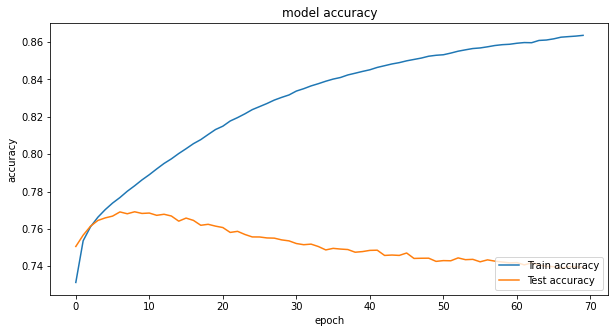

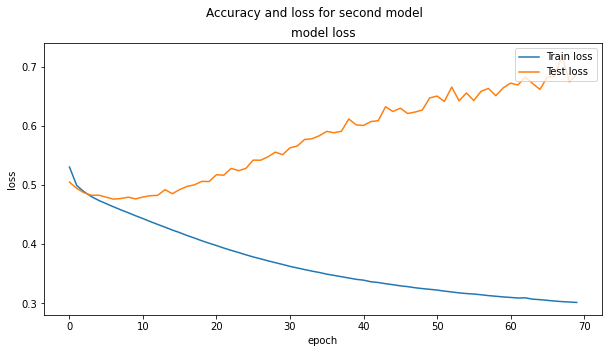

In [ ]:
#History for accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.suptitle('Accuracy and loss for second model')
plt.show()

In [ ]:
vec = CountVectorizer()

xeval=["I am love you "]
print(xeval)
xeval_numeric = vec.fit_transform(xeval).toarray() 
prediction=model.predict(xeval_numeric)
print(prediction)

['I am love you ']
[[0.2449933]]


In [ ]:
model.save("my_model2.h5")